In [93]:
import os
from typing import List, Tuple
import zipfile

from pathlib import Path
from timeit import default_timer as timer
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine
from utils import accuracy_fn

In [95]:

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [96]:

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 1. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use data_setup.py and the create_dataloaders() function

There's one thing we have to think about when loading: how to transform it?

And with torchvision 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

`Important point`:  When using a pretrained model (say from the internet when we want to take advantage of transfer learning), it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the (pretrained) model was actually trained on.

## 1.1 Creating a transform for torchvision.models (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within torchvision.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
```
normailze = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std =[0.229, 0.224, 0.225]
)
```
What this means is that our images, if we normalize them like this, will have the same data distribution as the pre-trained models.

And so if you want to learn the process of obtaining these values for mean and standard deviation, they are learned from the image net data set.

Thus one of the most important steps when using a Pre-trained model is that your data is formatted in a similar way to what your pre-trained model's data (data on which pretrained model was trained on).




Note: As of torchvision v0.13+, there's an update to how data transforms can be created using torchvision.models. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                                 std=[0.229, 0.224, 0.225])  # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),

manual_transforms = transforms.Compose([
            transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
            transforms.ToTensor(), # get images into range [0, 1]
            normalize]) # make sure our images have the same distribution as images in the
                        # ImageNet Dataset (where our pretrained models have been trained on)


# When using a pretrained model, it's important that your custom data going into the model is prepared
# in the same way as the original training data that went into the model.



# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1781eedd0>,
 ['pizza', 'steak', 'sushi'])

## 1.2 Creating a transform for torchvision.models (auto creation)

As of torchvision v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [98]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [99]:

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [100]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x17828ea10>,
 ['pizza', 'steak', 'sushi'])

# 2. Getting a pretrained model

There are various places to get a pretrained model, such as:

1. PyTorch domain libraries
2. Libraries like timm (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

# 3. Getting a pretrained model

## 3.1 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0 - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [ ]:

# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
# EfficientNet feature extractor

In [ ]:
# Base Layer/Feature Layers
# Feature Extractor, these layers extracts features from our images.
model.features



Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
# This turns learned features into a feature vector
# (by taking the average)
# So it's going to compress everything that the features section
# has extracted from our image into a single vector.
# And that vector is going to be of size 1280 because our linear layer
# here takes 1280 as input.
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
# Classifier head (Classifier layer)
# This is the actual classifier layer that is used to make predictions.
# This layer turns feature vector into prediction logits.
# This can be adjusted depending on the number of classes you have for your
# own data and needs.
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [22]:
# Getting a summary of our model with torchinfo.summary()
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"], # show these for each layer
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
# Count the number of parameters in the model
total_params = sum(
    param.numel() for param in model.parameters() # <- all params
	# param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
)

print(total_params)
print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{transforms}")

5288548
Total parameters of model: 5288548 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
<module 'torchvision.transforms' from '/Users/saalikmubeen/Dev/Machine Learning/personal-learning/venv/lib/python3.11/site-packages/torchvision/transforms/__init__.py'>


## 3.2 Freezing the base model and changing the output layer (classifier head) to suit our needs

With a `feature extractor model`, typically you will "freeze" the base layers (feature layers) of a pretrained/foundation model and update the output layers to suit your own problem.

In [36]:
# Freeze all of the base layers (weights and learnable parameters) in EffNetB0
for param in model.features.parameters():
#   print(param)
  param.requires_grad = False

In [37]:

len(class_names)

3

In [ ]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Upadate or change the classifier head of the pretrained
# model according to our needs and data.
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # Dropout layer
    nn.Linear(in_features=1280, # feature vector coming in after model.avgpool
              out_features=len(class_names)) # how many classes do we have?
    ).to(device)

model.classifier

# Now The only trainable parameters in our whole feature extraction model
# is the output layer.



Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [40]:
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4. Train model

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [50]:
print(len(train_dataloader))

8


In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start = timer()

# Train and test model
epochs = 5

# Create empty results dictionary
results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")

    ### Training
    train_loss = 0 # Total loss for one epoch
    train_acc = 0  # Total acc for one epoch

    for batch, (X, y) in enumerate(train_dataloader):

        model.train()

        # Forward pass
        # X is a tensor of 32 images i,e
        y_pred_logits = model.forward(X) # shape = torch.Size([32, 3])

        #  Calculate loss (per batch)
        loss = loss_fn(y_pred_logits, y) # loss per batch
        train_loss += loss # accumulate train loss

        y_pred_probs = torch.softmax(y_pred_logits, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1) # shape -> torch.Size([32])

        # Accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_pred_labels)
        train_acc += acc

        # Zero grad
        optimizer.zero_grad()

        # Backward Propagation
        loss.backward()

        # Gradient Descent
        optimizer.step()

        # Print out what's happening
        if batch % 2 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    # to calculate train loss average per batch
    # length of train dataloader = number of batches

    train_loss = train_loss / len(train_dataloader)
    train_acc /= len(train_dataloader)

     # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

    # Testing
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():

        for X_test, y_test in test_dataloader:

            # Forward pass
            y_test_logits = model(X_test)

            # Test Loss for each batch
            test_batch_loss = loss_fn(y_test_logits, y_test)
            test_loss += test_batch_loss

            y_test_probs = torch.softmax(y_test_logits, dim=1)
            y_test_labels = torch.argmax(y_test_probs, dim=1) # shape -> torch.Size([32])

            # Calculate accuracy
            acc = accuracy_fn(y_true=y_test, y_pred=y_test_labels)
            test_acc += acc

        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

        # Update results dictionary
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Print out what's happening after end of each epoch
    # This is the end of each epcoh of out training loop.
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


# Calculate training time
train_time_end = timer()
total_train_time_model = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=str(next(model.parameters()).device))

Epoch: 0
------
Looked at 0/225 samples.
Looked at 64/225 samples.
Looked at 128/225 samples.
Looked at 192/225 samples.

Train loss: 0.5138 | Test loss: 0.5944, Train acc: 94.1406, Test acc: 86.6477
Epoch: 1
------
Looked at 0/225 samples.
Looked at 64/225 samples.
Looked at 128/225 samples.
Looked at 192/225 samples.

Train loss: 0.5641 | Test loss: 0.5870, Train acc: 78.1250, Test acc: 81.5341
Epoch: 2
------
Looked at 0/225 samples.
Looked at 64/225 samples.
Looked at 128/225 samples.
Looked at 192/225 samples.

Train loss: 0.5392 | Test loss: 0.5164, Train acc: 80.8594, Test acc: 82.5758
Epoch: 3
------
Looked at 0/225 samples.
Looked at 64/225 samples.
Looked at 128/225 samples.
Looked at 192/225 samples.

Train loss: 0.4983 | Test loss: 0.5109, Train acc: 79.6875, Test acc: 85.6061
Epoch: 4
------
Looked at 0/225 samples.
Looked at 64/225 samples.
Looked at 128/225 samples.
Looked at 192/225 samples.

Train loss: 0.4181 | Test loss: 0.4959, Train acc: 95.3125, Test acc: 84.5644


In [86]:
results

{'train_loss': [0.3649398609995842,
  0.4189525954425335,
  0.41978316381573677,
  0.37027881294488907,
  0.31009309738874435],
 'train_acc': [0.96484375, 0.9453125, 0.96484375, 0.9609375, 0.97265625],
 'test_loss': [0.4834204614162445,
  0.5078219473361969,
  0.4575704336166382,
  0.43771769603093463,
  0.4376467168331146],
 'test_acc': [0.8456439393939394,
  0.8257575757575758,
  0.8361742424242425,
  0.8456439393939394,
  0.8456439393939394]}

## OR

In [80]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|████████████████████████▍                                                                                                 | 1/5 [01:33<06:13, 93.39s/it]

Epoch: 1 | train_loss: 0.3649 | train_acc: 0.9648 | test_loss: 0.4834 | test_acc: 0.8456



 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [03:06<04:39, 93.27s/it]

Epoch: 2 | train_loss: 0.4190 | train_acc: 0.9453 | test_loss: 0.5078 | test_acc: 0.8258



 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [04:39<03:06, 93.19s/it]

Epoch: 3 | train_loss: 0.4198 | train_acc: 0.9648 | test_loss: 0.4576 | test_acc: 0.8362



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [06:13<01:33, 93.52s/it]

Epoch: 4 | train_loss: 0.3703 | train_acc: 0.9609 | test_loss: 0.4377 | test_acc: 0.8456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:47<00:00, 93.57s/it]

Epoch: 5 | train_loss: 0.3101 | train_acc: 0.9727 | test_loss: 0.4376 | test_acc: 0.8456
[INFO] Total training time: 467.850 seconds


# 5. Evalaute model by plotting loss curves

In [84]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

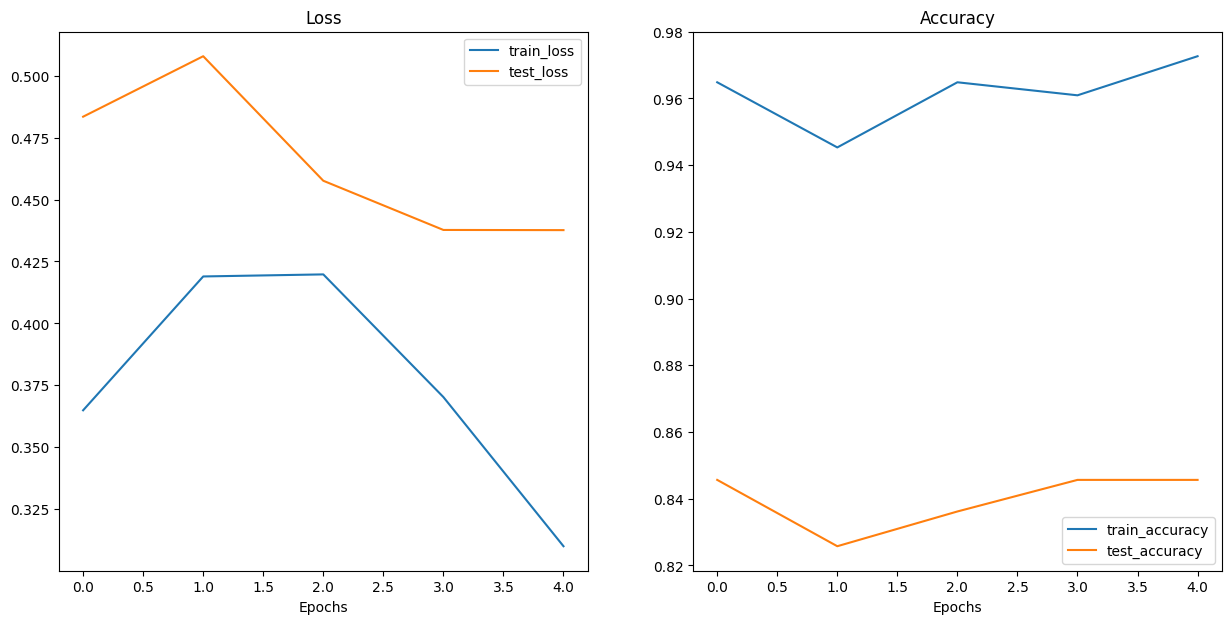

In [85]:

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make predictions on images from the test set

We have to make sure that our test/custom data is:

1. Same shape - images need to be same shape as model was trained on
2. Same datatype - custom data should be in the same data type
3. Same device - custom data/test data should be on the same device as the model
4. Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called pred_and_plot_image():

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using torch.softmax()
9. Convert model's prediction probabilities to prediction labels using torch.argmax()
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8

In [ ]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    # Our model expects input of shape
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # print(target_image_pred_probs.max())

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

In [63]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

[PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]


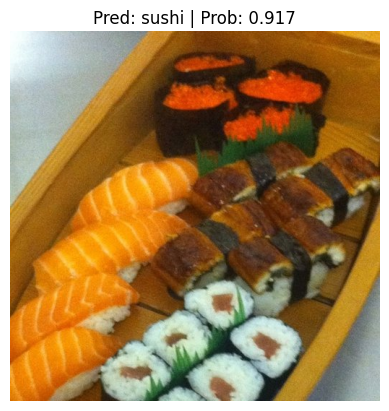

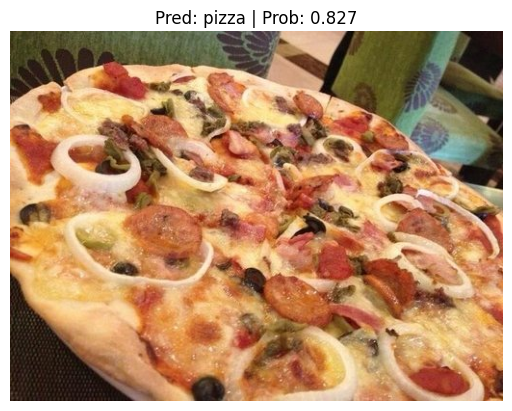

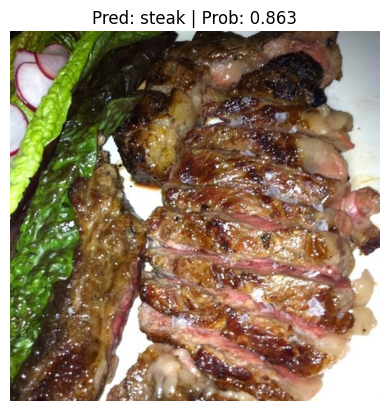

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

print(test_image_path_sample)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

 ## 6.1 Making predictions on a custom image

In [73]:
data_path

PosixPath('data')

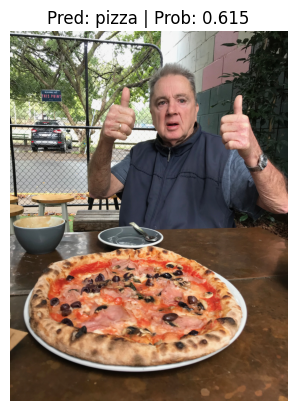

In [74]:
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)